## 20 Newsgroups

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn import datasets, model_selection
import tarfile
import re
import os
import pandas as pd
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import string
import spacy
from string import digits
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score 
from sklearn.pipeline import Pipeline
from spacy.en import English
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

Getting category names, i.e. folder names of 20 newsgroups folder

In [2]:
path = "20_newsgroups"
for root, dirs, files in os.walk(path, topdown=False):
    newsgroups = np.array(dirs)
print newsgroups

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


Reading files from first folder. Just use a for loop to read in from more folders.

In [3]:
x_train = []
y_train = []
x_test = []
y_test = []
for i in range(len(newsgroups)):
    x = []
    y=[]
    path = "20_newsgroups" + "/" + newsgroups[i]
    for root, dirs, files in os.walk(path):
        for name in files:
            f = open(path + "/" + name)
            x.append(f.read())
            y.append(newsgroups[i])
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(x, y, test_size = 0.3, random_state = 1)
    x_train.extend(X_train)
    x_test.extend(X_test)
    y_train.extend(Y_train)
    y_test.extend(Y_test)
#print x[1]

In [4]:
print len(x_train)
print len(x_test)
print len(y_train)
print len(y_test)

13997
6000
13997
6000


In [5]:
print 'Counts for each category \n%s.' % pd.DataFrame(y_train, columns = ['y_train']).y_train.value_counts()

print 'Counts for each category \n%s.' % pd.DataFrame(y_test, columns = ['y_test']).y_test.value_counts()

Counts for each category 
comp.os.ms-windows.misc     700
comp.windows.x              700
rec.motorcycles             700
sci.med                     700
talk.politics.mideast       700
rec.sport.baseball          700
comp.graphics               700
comp.sys.ibm.pc.hardware    700
rec.autos                   700
misc.forsale                700
sci.electronics             700
sci.space                   700
talk.politics.guns          700
talk.politics.misc          700
rec.sport.hockey            700
comp.sys.mac.hardware       700
sci.crypt                   700
talk.religion.misc          700
alt.atheism                 700
soc.religion.christian      697
Name: y_train, dtype: int64.
Counts for each category 
talk.politics.guns          300
sci.space                   300
rec.motorcycles             300
sci.med                     300
talk.politics.misc          300
talk.politics.mideast       300
rec.sport.hockey            300
comp.sys.mac.hardware       300
rec.sport.baseball     

Obtain metadatas From, Subject, Date, Organization, Sender from the headers of each file. Obtain Content from the body of each file and place in the original dataframe.

In [6]:
# Creating the dataframe and assigning columns
def create_dataframe(x): 
    original = pd.DataFrame()
    original = original.assign(Path = '')
    original = original.assign(From = '')
    original = original.assign(Subject = '')
    original = original.assign(Date = '')
    original = original.assign(Organization = '')
    original = original.assign(Sender = '')
    original = original.assign(Content = '')
    original = original.assign(Lines = '')
    original = original.assign(Nntp_posting_host = '')
    original = original.assign(Message_id = '')
    original = original.assign(Reply_to = '')
    original = original.assign(References = '')
    #print original.dtypes

    # Placing the metadatas and content in the respective cells of the dataframe
    for i in range(len(x)):
        data = x[i].split("\n\n", 1)
        email_content = ''
        meta = sorted(data[0].split("\n"))
        for k in meta:
            z = np.array(k.split(":", 1))
            meta_title = z[0].capitalize().replace('-', '_')
            if meta_title in list(original):
                try:
                    original.at[i, meta_title] = z[1]
                except ValueError:
                    original.at[i, z[0]] = np.NaN
        original.at[i, 'Content'] = data[1]
    return original

In [7]:
train_x = create_dataframe(x_train)
train_x.count()

Path                 13997
From                 13997
Subject              13997
Date                 13997
Organization         13415
Sender                7618
Content              13997
Lines                13953
Nntp_posting_host     5974
Message_id           13997
Reply_to              2102
References            8750
dtype: int64

In [8]:
test_x = create_dataframe(x_test)
test_x.count()

Path                 6000
From                 6000
Subject              6000
Date                 6000
Organization         5731
Sender               3254
Content              6000
Lines                5984
Nntp_posting_host    2601
Message_id           6000
Reply_to              923
References           3758
dtype: int64

Saving to csv

In [9]:
df_y_train = pd.DataFrame(y_train, columns = ['categories'])
df_y_test = pd.DataFrame(y_test, columns = ['categories'])

In [ ]:
train_x.to_csv('train_x.csv')
test_x.to_csv('test_x.csv')
df_y_train.to_csv('y_train.csv')
df_y_test.to_csv('y_test.csv')

## Import
Importing the csv files

In [ ]:
df_train_x = pd.read_csv('train_x.csv')
df_test_x = pd.read_csv('test_x.csv')
df_train_y = pd.read_csv('y_train.csv')
df_test_y = pd.read_csv('y_test.csv')

In [ ]:
df_train_x.loc[14]

## Emails
Extract email address from From and Sender column. From and Sender names were not considered as not much info can be gotten. 
Flag whether the document is from an educational institution by checking the domain for .edu
Extra: extract domain, country etc

In [10]:
def process_emails(original):
    # Extracting the email addresses from From column
    original['Email_from'] = original.From.map(lambda x : re.search(r'[\w\.-]+@[\w\.-]+', x).group(0) 
                                               if re.search(r'[\w\.-]+@[\w\.-]+', x) is not None 
                                               else np.NaN)

    # Extracting the email addresses from Sender column
    original['Email_sender'] = original.Sender.map(lambda x : np.NaN 
                                                   if pd.isnull(x) 
                                                   else re.search(r'[\w\.-]+@[\w\.-]+', x).group(0) 
                                                   if re.search(r'[\w\.-]+@[\w\.-]+', x) is not None 
                                                   else np.NaN)

    # flag as educational organisation if the email address has .edu domain
    original['Edu_org'] = original.Email_from.map(lambda x : 1 if isinstance(x, basestring) and x[len(x) - 3:].find('edu') is not -1 
                                                  else 0)
    return original

In [11]:
train_x = process_emails(train_x)
train_x.head()

,Path,From,Subject,Date,Organization,Sender,Content,Lines,Nntp_posting_host,Message_id,Reply_to,References,Email_from,Email_sender,Edu_org
0,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,livesey@solntze.wpd.sgi.com (Jon Livesey),Re: Yet more Rushdie [Re: ISLAMIC LAW],23 Apr 1993 21:02:00 GMT,sgi,NaN,"In article <116533@bu.edu>, jaeger@buphy.bu.ed...",27,solntze.wpd.sgi.com,<1r9lg8$92u@fido.asd.sgi.com>,NaN,<1qla0g$afp@fido.asd.sgi.com> <115793@bu.edu>...,livesey@solntze.wpd.sgi.com,NaN,0
1,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,halat@pooh.bears (Jim Halat),"Re: After 2000 years, can we say that Christi...",23 Apr 93 18:50:18 GMT,NaN,news@bear.com,"In article <markp.735230393@elvis.wri.com>, ma...",25,NaN,<30185@ursa.bear.com>,halat@pooh.bears (Jim Halat),<30114@ursa.bear.com# <1qie61$fkt@horus.ap.mc...,halat@pooh.bears,news@bear.com,0
2,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,sham@cs.arizona.edu (Shamim Zvonko Mohamed),Re: Death Penalty / Gulf War (long),21 Apr 93 20:33:53 GMT,"U of Arizona CS Dept, Tucson",NaN,This is the most unmitigated bilge I've seen i...,62,NaN,<37501@optima.cs.arizona.edu>,NaN,<930420.105805.0x8.rusnews.w165w@mantis.co.uk>,sham@cs.arizona.edu,NaN,1
3,cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cm...,dewey@risc.sps.mot.com (Dewey Henize),Re: sci.skeptic.religion (Was: Why ALT.atheism?),13 Apr 1993 18:43:48 -0500,"Motorola, Inc. -- Austin,TX",NaN,In article <93103.071613J5J@psuvm.psu.edu> Joh...,33,thug.sps.mot.com,<1qfj7kINNked@thug.sps.mot.com>,NaN,<1993Apr13.040149.25394@cs.ucla.edu> <1993Apr...,dewey@risc.sps.mot.com,NaN,0
4,cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cm...,mathew <mathew@mantis.co.uk>,"Re: After 2000 years, can we say that Christi...","Wed, 21 Apr 1993 10:25:25 +0100","Mantis Consultants, Cambridge. UK.",NaN,frank@D012S658.uucp (Frank O'Dwyer) writes:\n>...,21,NaN,<930421.102525.9Y9.rusnews.w165w@mantis.co.uk>,NaN,<1qtsmc$39j@horus.ap.mchp.sni.de> <930420.100...,mathew@mantis.co.uk,NaN,0


## Subject
For Subject, remove Re: (maybe indicate that its a reply message), throw to content

In [12]:
def process_subject(original):
    # Process the subject to remove Re:
    original['Subject_processed'] = original.Subject.map(lambda x : x[x.find("FAQ:") + 5:] 
                                                         if x.find("FAQ:") is not -1 
                                                         else x[x.find("Re:") + 4:] if x.find("Re:") is not -1 and x.find("Re", 5) is -1
                                                         else x[x.find("Re:") + 4:x.find("Re", 5)] if x.find("Re:") is not -1
                                                         else x)

    # Reply_msg = 1 if the document is a reply message, otherwise 0
    original['Reply_msg'] = original.Subject.map(lambda x : 1 
                                                 if x.find("Re:") == 1 
                                                 else 0)

    # Adds the processed subject to Content column
    original['Content'] = original.Content + " " + original.Subject_processed

    # Removes Subject_processed column as they are appended to content column
    del original['Subject_processed']
    return original

In [13]:
train_x = process_subject(train_x)
train_x.head()

,Path,From,Subject,Date,Organization,Sender,Content,Lines,Nntp_posting_host,Message_id,Reply_to,References,Email_from,Email_sender,Edu_org,Reply_msg
0,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,livesey@solntze.wpd.sgi.com (Jon Livesey),Re: Yet more Rushdie [Re: ISLAMIC LAW],23 Apr 1993 21:02:00 GMT,sgi,NaN,"In article <116533@bu.edu>, jaeger@buphy.bu.ed...",27,solntze.wpd.sgi.com,<1r9lg8$92u@fido.asd.sgi.com>,NaN,<1qla0g$afp@fido.asd.sgi.com> <115793@bu.edu>...,livesey@solntze.wpd.sgi.com,NaN,0,1
1,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,halat@pooh.bears (Jim Halat),"Re: After 2000 years, can we say that Christi...",23 Apr 93 18:50:18 GMT,NaN,news@bear.com,"In article <markp.735230393@elvis.wri.com>, ma...",25,NaN,<30185@ursa.bear.com>,halat@pooh.bears (Jim Halat),<30114@ursa.bear.com# <1qie61$fkt@horus.ap.mc...,halat@pooh.bears,news@bear.com,0,1
2,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,sham@cs.arizona.edu (Shamim Zvonko Mohamed),Re: Death Penalty / Gulf War (long),21 Apr 93 20:33:53 GMT,"U of Arizona CS Dept, Tucson",NaN,This is the most unmitigated bilge I've seen i...,62,NaN,<37501@optima.cs.arizona.edu>,NaN,<930420.105805.0x8.rusnews.w165w@mantis.co.uk>,sham@cs.arizona.edu,NaN,1,1
3,cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cm...,dewey@risc.sps.mot.com (Dewey Henize),Re: sci.skeptic.religion (Was: Why ALT.atheism?),13 Apr 1993 18:43:48 -0500,"Motorola, Inc. -- Austin,TX",NaN,In article <93103.071613J5J@psuvm.psu.edu> Joh...,33,thug.sps.mot.com,<1qfj7kINNked@thug.sps.mot.com>,NaN,<1993Apr13.040149.25394@cs.ucla.edu> <1993Apr...,dewey@risc.sps.mot.com,NaN,0,1
4,cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cm...,mathew <mathew@mantis.co.uk>,"Re: After 2000 years, can we say that Christi...","Wed, 21 Apr 1993 10:25:25 +0100","Mantis Consultants, Cambridge. UK.",NaN,frank@D012S658.uucp (Frank O'Dwyer) writes:\n>...,21,NaN,<930421.102525.9Y9.rusnews.w165w@mantis.co.uk>,NaN,<1qtsmc$39j@horus.ap.mchp.sni.de> <930420.100...,mathew@mantis.co.uk,NaN,0,1


## Date
For Date, extract month and year (year seems to be all in 1993)

In [14]:
def process_date(original):
    # Extracting the Month from the Date column
    month_dict = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    original['Month'] = original.Date.map(lambda y : ''.join(filter(lambda x: x.lower() in month_dict, y.split())))

    # Extracting the Year from the Date column
    original['Year'] = original.Date.map(lambda x : ''.join([x[x.lower().find(i):].split(' ')[1] 
                                                             for i in month_dict 
                                                             if x.lower().find(i) is not -1]))
    original['Year'] = original.Year.map(lambda x : x[2:] 
                                         if len(x) is 4 
                                         else x)
    return original

In [15]:
train_x = process_date(train_x)
train_x.head()

,Path,From,Subject,Date,Organization,Sender,Content,Lines,Nntp_posting_host,Message_id,Reply_to,References,Email_from,Email_sender,Edu_org,Reply_msg,Month,Year
0,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,livesey@solntze.wpd.sgi.com (Jon Livesey),Re: Yet more Rushdie [Re: ISLAMIC LAW],23 Apr 1993 21:02:00 GMT,sgi,NaN,"In article <116533@bu.edu>, jaeger@buphy.bu.ed...",27,solntze.wpd.sgi.com,<1r9lg8$92u@fido.asd.sgi.com>,NaN,<1qla0g$afp@fido.asd.sgi.com> <115793@bu.edu>...,livesey@solntze.wpd.sgi.com,NaN,0,1,Apr,93
1,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,halat@pooh.bears (Jim Halat),"Re: After 2000 years, can we say that Christi...",23 Apr 93 18:50:18 GMT,NaN,news@bear.com,"In article <markp.735230393@elvis.wri.com>, ma...",25,NaN,<30185@ursa.bear.com>,halat@pooh.bears (Jim Halat),<30114@ursa.bear.com# <1qie61$fkt@horus.ap.mc...,halat@pooh.bears,news@bear.com,0,1,Apr,93
2,cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.c...,sham@cs.arizona.edu (Shamim Zvonko Mohamed),Re: Death Penalty / Gulf War (long),21 Apr 93 20:33:53 GMT,"U of Arizona CS Dept, Tucson",NaN,This is the most unmitigated bilge I've seen i...,62,NaN,<37501@optima.cs.arizona.edu>,NaN,<930420.105805.0x8.rusnews.w165w@mantis.co.uk>,sham@cs.arizona.edu,NaN,1,1,Apr,93
3,cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cm...,dewey@risc.sps.mot.com (Dewey Henize),Re: sci.skeptic.religion (Was: Why ALT.atheism?),13 Apr 1993 18:43:48 -0500,"Motorola, Inc. -- Austin,TX",NaN,In article <93103.071613J5J@psuvm.psu.edu> Joh...,33,thug.sps.mot.com,<1qfj7kINNked@thug.sps.mot.com>,NaN,<1993Apr13.040149.25394@cs.ucla.edu> <1993Apr...,dewey@risc.sps.mot.com,NaN,0,1,Apr,93
4,cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cm...,mathew <mathew@mantis.co.uk>,"Re: After 2000 years, can we say that Christi...","Wed, 21 Apr 1993 10:25:25 +0100","Mantis Consultants, Cambridge. UK.",NaN,frank@D012S658.uucp (Frank O'Dwyer) writes:\n>...,21,NaN,<930421.102525.9Y9.rusnews.w165w@mantis.co.uk>,NaN,<1qtsmc$39j@horus.ap.mchp.sni.de> <930420.100...,mathew@mantis.co.uk,NaN,0,1,Apr,93


Checking the columns of original dataframe

In [16]:
list(train_x)

['Path',
 'From',
 'Subject',
 'Date',
 'Organization',
 'Sender',
 'Content',
 'Lines',
 'Nntp_posting_host',
 'Message_id',
 'Reply_to',
 'References',
 'Email_from',
 'Email_sender',
 'Edu_org',
 'Reply_msg',
 'Month',
 'Year']

The following shows that some columns have missing values, such as Organisation, Sender, Lines, Email_from, and Email_sender (might need to remove email_from and email_sender and subject)

In [17]:
train_x.count()

Path                 13997
From                 13997
Subject              13997
Date                 13997
Organization         13415
Sender                7618
Content              13997
Lines                13953
Nntp_posting_host     5974
Message_id           13997
Reply_to              2102
References            8750
Email_from           13750
Email_sender          7431
Edu_org              13997
Reply_msg            13997
Month                13997
Year                 13997
dtype: int64

Sanity check, when using full dataset, if all years are in 93, remove the column

In [18]:
train_x.groupby('Year').count()['Content']

Year
92        2
93    13995
Name: Content, dtype: int64

After checking, all years (except two cases) are in 1993 so year column is removed.

In [19]:
del train_x['Year']
print list(train_x)

['Path', 'From', 'Subject', 'Date', 'Organization', 'Sender', 'Content', 'Lines', 'Nntp_posting_host', 'Message_id', 'Reply_to', 'References', 'Email_from', 'Email_sender', 'Edu_org', 'Reply_msg', 'Month']


Checking the Month Column, we see that there is one entry which is empty. Further checks shows that it is because the month is spelt as April instead of the usual Apr, therefore the discrepancy.

In [20]:
train_x.groupby('Month').count()['Content']

Month
           1
APR       20
Apr    12836
Feb        2
Jun        2
MAY        3
Mar       17
May     1116
Name: Content, dtype: int64

In [21]:
emp = ''
for i in range(len(train_x.Month)):
    if train_x.Month[i] == '':
        emp = i
print train_x.Date[emp]
train_x.at[emp, 'Month'] = 'Apr'
train_x.groupby('Month').count()['Content']

 Wednesday, 14 April 1993 12:14:23 MST


Month
APR       20
Apr    12837
Feb        2
Jun        2
MAY        3
Mar       17
May     1116
Name: Content, dtype: int64

## Educational Organisation

Edu_org
0    8966
1    5031
Name: Content, dtype: int64


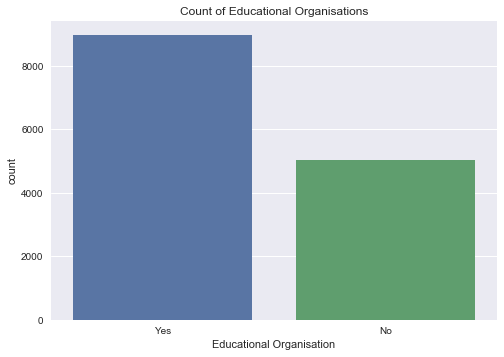

In [22]:
print train_x.groupby('Edu_org').count()['Content']
ax = seaborn.countplot(x='Edu_org', data=train_x)
ax.set(title = 'Count of Educational Organisations', xlabel = 'Educational Organisation', xticklabels = ["Yes", 'No'])
plt.show()

Reply_msg
0    4737
1    9260
Name: Content, dtype: int64


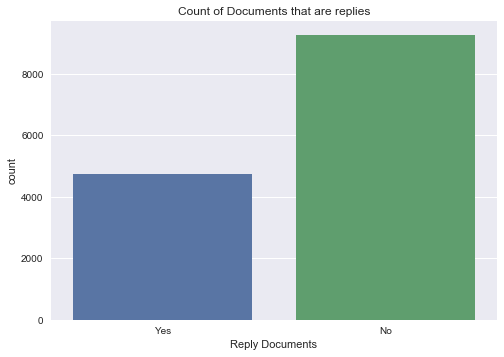

In [23]:
print train_x.groupby('Reply_msg').count()['Content']
ax = seaborn.countplot(x='Reply_msg', data=train_x)
ax.set(title = 'Count of Documents that are replies', xlabel = 'Reply Documents', xticklabels = ["Yes", 'No'])
plt.show()

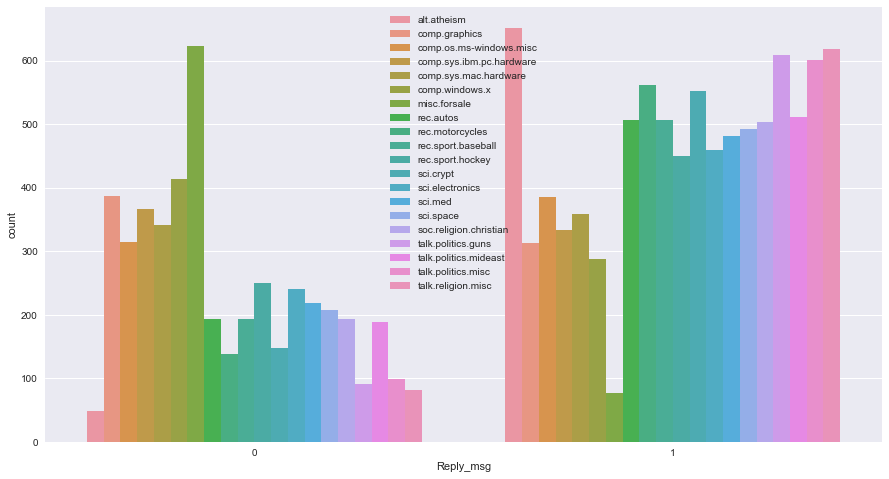

In [115]:

plt.figure(figsize=(15,8))
ax = seaborn.countplot(x='Reply_msg', hue = y_train, data=train_x)

## Cleaning, preprocessing, modelling on Content

In [24]:
nlp = spacy.load('en')

In [25]:
def clean_text(document):
    # Removes emails
    document = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', document)
    
    # Removes URLs
    document = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', document)
    
    # Removes punctuations
    document = document.translate(None, string.punctuation)
    
    # Change to lowercase
    document = document.lower()
    
    # Removes newline characters
    document = ' '.join(document.split('\n'))
    
    # Removes ASCII
    document = re.sub(r'[^\x00-\x7F]+',' ', document)
    
    # Removes numbers
    document = document.translate(None, digits)
    
    # Replace multiple spaces with one space
    document = ' '.join(document.split())
    #document = nlp(unicode(document))
    
    return document

In [26]:
parser = English()

In [27]:
def spacy_tokenizer(document):
    document = parser(unicode(document))
    # Removes stopwords
    document = [tok for tok in document if (str(tok) not in stopwords)]
    return document

In [28]:
train_x_content = train_x.Content.map(lambda x : clean_text(x))
#train_x_content = train_x_content.map(lambda x : spacy_tokenizer(x))

In [29]:
test_x_content = test_x.Content.map(lambda x : clean_text(x))
#test_x_content = test_x_content.map(lambda x : spacy_tokenizer(x))

## Vectorizing
Transforming into DTM

In [77]:
count_vect = CountVectorizer()
linear_svc = LinearSVC(random_state = 1)
nb = MultinomialNB()
pipe_linearsvc = Pipeline([('count_vect', count_vect), ('linear_svc', linear_svc)])
pipe_nb = Pipeline([('count_vect', count_vect), ('nb', nb)])

## Stemming

In [31]:
porter_stemmer = PorterStemmer()
train_x_stem = train_x_content.map(lambda x : ' '.join([porter_stemmer.stem(str(i)) for i in x.split()]))
test_x_stem = test_x_content.map(lambda x : ' '.join([porter_stemmer.stem(str(i)) for i in x.split()]))

Linear SVC

In [78]:
pipe_linearsvc.fit(train_x_stem, y_train)
pred = pipe_linearsvc.predict(test_x_stem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.762666666667


Multinomial Naive Bayes

In [79]:
pipe_nb.fit(np.array(train_x_stem), y_train)
pred = pipe_nb.predict(test_x_stem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.764


## Lemmatizing

Linear SVC

In [45]:
wordnet_lemmatizer = WordNetLemmatizer()
train_x_lem = train_x_content.map(lambda x : ' '.join([wordnet_lemmatizer.lemmatize(str(i)) for i in x.split()]))
test_x_lem = test_x_content.map(lambda x : ' '.join([wordnet_lemmatizer.lemmatize(str(i)) for i in x.split()]))

In [80]:
pipe_linearsvc.fit(train_x_lem, y_train)
pred = pipe_linearsvc.predict(test_x_lem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.767833333333


Multinomial Naive Bayes

In [81]:
pipe_nb.fit(np.array(train_x_lem), y_train)
pred = pipe_nb.predict(test_x_lem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.768166666667


A look at the count of the feature names when the content portion has been through lemmatizing and stemming shows that the number of words are:

| Stemming | Lemmatizing |
|----------|-------------|
|  93242   |  108063     |  
These are much higher than the number of documents which is not optimal for some models, therefore some way of reducing the terms is needed.

In [82]:
count_vect.fit(train_x_stem)
print len(count_vect.get_feature_names())
count_vect.fit(train_x_lem)
print len(count_vect.get_feature_names())

93242
108063


Ignoring terms with document frequency lower than 10

In [83]:
count_vect = CountVectorizer(min_df = 10)
count_vect.fit(train_x_stem)
print len(count_vect.get_feature_names())
count_vect.fit(train_x_lem)
print len(count_vect.get_feature_names())

10156
12555


In [87]:
pipe_linearsvc = Pipeline([('count_vect', count_vect), ('linear_svc', linear_svc)])
pipe_linearsvc.fit(train_x_stem, y_train)
pred = pipe_linearsvc.predict(test_x_stem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.738666666667


In [88]:
pipe_linearsvc.fit(train_x_lem, y_train)
pred = pipe_linearsvc.predict(test_x_lem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.746666666667


In [90]:
pipe_nb = Pipeline([('count_vect', count_vect), ('nb', nb)])
pipe_nb.fit(train_x_stem, y_train)
pred = pipe_nb.predict(test_x_stem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.793333333333


In [91]:
pipe_nb = Pipeline([('count_vect', count_vect), ('nb', nb)])
pipe_nb.fit(train_x_lem, y_train)
pred = pipe_nb.predict(test_x_lem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.796166666667


## TF-IDF

In [105]:
tfidf_vect = TfidfVectorizer(min_df = 10)
tfidf_vect.fit(train_x_stem)
print len(tfidf_vect.get_feature_names())
tfidf_vect.fit(train_x_lem)
print len(tfidf_vect.get_feature_names())

10156
12555


In [106]:
pipe_linearsvc = Pipeline([('count_vect', tfidf_vect), ('linear_svc', linear_svc)])
pipe_linearsvc.fit(train_x_stem, y_train)
pred = pipe_linearsvc.predict(test_x_stem)
pred_train = pipe_linearsvc.predict(train_x_stem)
print "Accuracy:", accuracy_score(y_test, pred)
print "Train Accuracy:", accuracy_score(y_train, pred_train)

Accuracy: 0.831666666667
Train Accuracy: 0.975994856041


In [99]:
pipe_linearsvc.fit(train_x_lem, y_train)
pred = pipe_linearsvc.predict(test_x_lem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.835333333333


In [100]:
pipe_nb = Pipeline([('count_vect', tfidf_vect), ('nb', nb)])
pipe_nb.fit(train_x_stem, y_train)
pred = pipe_nb.predict(test_x_stem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.794


In [101]:
pipe_nb.fit(train_x_lem, y_train)
pred = pipe_nb.predict(test_x_lem)
print "Accuracy:", accuracy_score(y_test, pred)

Accuracy: 0.7975
